In [0]:
# Importações
from pyspark.sql import SparkSession # importa a biblioteca que cria a seção do spark
from pyspark.sql.functions import isnan, when, count, col
from pyspark.mllib.stat import Statistics
from pyspark.ml.evaluation import ClusteringEvaluator  #biblioteca utilizada para a avaliação em cada um dos clusters
from pyspark.ml.clustering import KMeans #biblioteca utilizada para a criação do modelo de clusterização utilizando o K-means
from pyspark.ml.feature import VectorAssembler  #transformando os dados em vetores de características
import matplotlib.pyplot as plt

In [0]:
# Iniciar seção para a utilização do spark e criar caso não exista
secao_spark = SparkSession.builder.appName("desafio_tpd").getOrCreate()

In [0]:
# Definir diretorio da fonte de dados e carregar
diretorio_data_set="/FileStore/tables/Mall_Customers.csv"
data_set = secao_spark.read.format("csv").options(header="true", inferschema="true").load(diretorio_data_set)

In [0]:
# Visualizar as 5 primeiras instâncias do dataset
data_set.show(5,False)

+----------+------+---+------------------+----------------------+
|CustomerID|Genre |Age|Annual Income (k$)|Spending Score (1-100)|
+----------+------+---+------------------+----------------------+
|1         |Male  |19 |15                |39                    |
|2         |Male  |21 |15                |81                    |
|3         |Female|20 |16                |6                     |
|4         |Female|23 |16                |77                    |
|5         |Female|31 |17                |40                    |
+----------+------+---+------------------+----------------------+
only showing top 5 rows



In [0]:
# Visualizar colunas do dataset
data_set.columns

Out[44]: ['CustomerID', 'Genre', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']

In [0]:
# Visualizar o schema inferido pelas variáveis
data_set.printSchema()

root
 |-- CustomerID: integer (nullable = true)
 |-- Genre: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Annual Income (k$): integer (nullable = true)
 |-- Spending Score (1-100): integer (nullable = true)



In [0]:
# Contar registros
data_set.count()

Out[46]: 200

In [0]:
# Verificar existência de valores nulos
data_set.select([count(when(isnan(c), c)).alias(c) for c in data_set.columns]).show()

+----------+-----+---+------------------+----------------------+
|CustomerID|Genre|Age|Annual Income (k$)|Spending Score (1-100)|
+----------+-----+---+------------------+----------------------+
|         0|    0|  0|                 0|                     0|
+----------+-----+---+------------------+----------------------+



In [0]:
# Visualizar estatísticas do dataset
data_set.describe().show()

+-------+------------------+------+-----------------+------------------+----------------------+
|summary|        CustomerID| Genre|              Age|Annual Income (k$)|Spending Score (1-100)|
+-------+------------------+------+-----------------+------------------+----------------------+
|  count|               200|   200|              200|               200|                   200|
|   mean|             100.5|  null|            38.85|             60.56|                  50.2|
| stddev|57.879184513951124|  null|13.96900733155888| 26.26472116527124|    25.823521668370173|
|    min|                 1|Female|               18|                15|                     1|
|    max|               200|  Male|               70|               137|                    99|
+-------+------------------+------+-----------------+------------------+----------------------+



In [0]:
# Verificar outliers com boxplot
# Selecionar algumas colunas
data_set_outliers=data_set.select([c for c in data_set.columns if c in ['Age','Annual Income (k$)','Spending Score (1-100)']])
data_set_outliers.show()

+---+------------------+----------------------+
|Age|Annual Income (k$)|Spending Score (1-100)|
+---+------------------+----------------------+
| 19|                15|                    39|
| 21|                15|                    81|
| 20|                16|                     6|
| 23|                16|                    77|
| 31|                17|                    40|
| 22|                17|                    76|
| 35|                18|                     6|
| 23|                18|                    94|
| 64|                19|                     3|
| 30|                19|                    72|
| 67|                19|                    14|
| 35|                19|                    99|
| 58|                20|                    15|
| 24|                20|                    77|
| 37|                20|                    13|
| 22|                20|                    79|
| 35|                21|                    35|
| 20|                21|                

In [0]:
# Visualizar com boxplot
display(data_set_outliers)

Age,Annual Income (k$),Spending Score (1-100)
19,15,39
21,15,81
20,16,6
23,16,77
31,17,40
22,17,76
35,18,6
23,18,94
64,19,3
30,19,72


In [0]:
# Explorar o dataset
display(data_set.select(["Genre","Annual Income (k$)"]))

Genre,Annual Income (k$)
Male,15
Male,15
Female,16
Female,16
Female,17
Female,17
Female,18
Female,18
Male,19
Female,19


In [0]:
# Verificar distribuição dos consumidores pela idade usando histograma e 20 intervalos
display(data_set.select(["Age"]))

Age
19
21
20
23
31
22
35
23
64
30


In [0]:
# Verificar distribuição da idade por sexo
display(data_set.select(["Age","Genre"]))

Age,Genre
19,Male
21,Male
20,Female
23,Female
31,Female
22,Female
35,Female
23,Female
64,Male
30,Female


In [0]:
# Verificar as notas atribuidas por gênero 
display(data_set.select(["Spending Score (1-100)","Genre"]))

Spending Score (1-100),Genre
39,Male
81,Male
6,Female
77,Female
40,Female
76,Female
6,Female
94,Female
3,Male
72,Female


In [0]:
# Analisar correlação entre Idade e Nota Atribuída
rdd_1=data_set.select("Spending Score (1-100)").rdd.flatMap(lambda x:x)  #utilizada para transforma das colunas do dataframe em colunas para serem empregadas na análise de correlaçoes
rdd_2=data_set.select("Age").rdd.flatMap(lambda x:x)

In [0]:
# Definir coeficiente de correlação
Statistics.corr(rdd_1,rdd_2,method="pearson")

Out[56]: -0.32722684603909014

In [0]:
data_set.stat.corr("Age","Annual Income (k$)",method="pearson")

Out[57]: -0.01239804273606026

In [0]:
# Analisar correlação por gênero - homens
homens=data_set[data_set.Genre=='Male']
homens.show()

+----------+-----+---+------------------+----------------------+
|CustomerID|Genre|Age|Annual Income (k$)|Spending Score (1-100)|
+----------+-----+---+------------------+----------------------+
|         1| Male| 19|                15|                    39|
|         2| Male| 21|                15|                    81|
|         9| Male| 64|                19|                     3|
|        11| Male| 67|                19|                    14|
|        15| Male| 37|                20|                    13|
|        16| Male| 22|                20|                    79|
|        18| Male| 20|                21|                    66|
|        19| Male| 52|                23|                    29|
|        21| Male| 35|                24|                    35|
|        22| Male| 25|                24|                    73|
|        24| Male| 31|                25|                    73|
|        26| Male| 29|                28|                    82|
|        28| Male| 35|   

In [0]:
# Analisar correlação por gênero - mulheres
mulheres=data_set[data_set.Genre=='Female']
mulheres.show()

+----------+------+---+------------------+----------------------+
|CustomerID| Genre|Age|Annual Income (k$)|Spending Score (1-100)|
+----------+------+---+------------------+----------------------+
|         3|Female| 20|                16|                     6|
|         4|Female| 23|                16|                    77|
|         5|Female| 31|                17|                    40|
|         6|Female| 22|                17|                    76|
|         7|Female| 35|                18|                     6|
|         8|Female| 23|                18|                    94|
|        10|Female| 30|                19|                    72|
|        12|Female| 35|                19|                    99|
|        13|Female| 58|                20|                    15|
|        14|Female| 24|                20|                    77|
|        17|Female| 35|                21|                    35|
|        20|Female| 35|                23|                    98|
|        2

In [0]:
# Visualizar correlação entre Idade e o Salário Anual - Homens
homens.stat.corr("Age","Spending Score (1-100)",method="pearson")

Out[60]: -0.27962764627493125

In [0]:
# Visualizar correlação entre Idade e o Salário Anual - Mulheres
mulheres.stat.corr("Age","Spending Score (1-100)",method="pearson")

Out[61]: -0.3754385837780473

In [0]:
# Aplicar Kmeans
# Transformar dados em vetor (definir o objeto)
vetor_assembler = VectorAssembler(inputCols=["Spending Score (1-100)","Annual Income (k$)"], outputCol="features")
# Aplicar a transformação
df_novo = vetor_assembler.transform(data_set)
df_novo.show()

+----------+------+---+------------------+----------------------+-----------+
|CustomerID| Genre|Age|Annual Income (k$)|Spending Score (1-100)|   features|
+----------+------+---+------------------+----------------------+-----------+
|         1|  Male| 19|                15|                    39|[39.0,15.0]|
|         2|  Male| 21|                15|                    81|[81.0,15.0]|
|         3|Female| 20|                16|                     6| [6.0,16.0]|
|         4|Female| 23|                16|                    77|[77.0,16.0]|
|         5|Female| 31|                17|                    40|[40.0,17.0]|
|         6|Female| 22|                17|                    76|[76.0,17.0]|
|         7|Female| 35|                18|                     6| [6.0,18.0]|
|         8|Female| 23|                18|                    94|[94.0,18.0]|
|         9|  Male| 64|                19|                     3| [3.0,19.0]|
|        10|Female| 30|                19|                    72

In [0]:
# Aplicar clusterização
# Declarar o objeto - 5 clusters
kmeans = KMeans(k=5, seed=1)
# Aplicar o treinamento 
model = kmeans.fit(df_novo.select('features'))

In [0]:
# Criar dataset com indicação sobre qual cluster cada conjunto de dados foi adicionado
df_final = model.transform(df_novo)
df_final.show() 

+----------+------+---+------------------+----------------------+-----------+----------+
|CustomerID| Genre|Age|Annual Income (k$)|Spending Score (1-100)|   features|prediction|
+----------+------+---+------------------+----------------------+-----------+----------+
|         1|  Male| 19|                15|                    39|[39.0,15.0]|         4|
|         2|  Male| 21|                15|                    81|[81.0,15.0]|         2|
|         3|Female| 20|                16|                     6| [6.0,16.0]|         4|
|         4|Female| 23|                16|                    77|[77.0,16.0]|         2|
|         5|Female| 31|                17|                    40|[40.0,17.0]|         4|
|         6|Female| 22|                17|                    76|[76.0,17.0]|         2|
|         7|Female| 35|                18|                     6| [6.0,18.0]|         4|
|         8|Female| 23|                18|                    94|[94.0,18.0]|         2|
|         9|  Male| 6

In [0]:
# Visualizar estatísticas
data_set.describe().show()

+-------+------------------+------+-----------------+------------------+----------------------+
|summary|        CustomerID| Genre|              Age|Annual Income (k$)|Spending Score (1-100)|
+-------+------------------+------+-----------------+------------------+----------------------+
|  count|               200|   200|              200|               200|                   200|
|   mean|             100.5|  null|            38.85|             60.56|                  50.2|
| stddev|57.879184513951124|  null|13.96900733155888| 26.26472116527124|    25.823521668370173|
|    min|                 1|Female|               18|                15|                     1|
|    max|               200|  Male|               70|               137|                    99|
+-------+------------------+------+-----------------+------------------+----------------------+



In [0]:
# Visualizar a contagem para cada predição
df_final.groupby('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   39|
|         3|   81|
|         4|   23|
|         2|   22|
|         0|   35|
+----------+-----+



In [0]:
# Transformando os dados utilizando pandas 
data_set_pandas = df_final.toPandas().set_index('CustomerID')
data_set_pandas.head()

/databricks/spark/python/pyspark/sql/pandas/conversion.py:92: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field features. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)


,Genre,Age,Annual Income (k$),Spending Score (1-100),features,prediction
CustomerID,,,,,,
1,Male,19,15,39,"[39.0, 15.0]",4
2,Male,21,15,81,"[81.0, 15.0]",2
3,Female,20,16,6,"[6.0, 16.0]",4
4,Female,23,16,77,"[77.0, 16.0]",2
5,Female,31,17,40,"[40.0, 17.0]",4


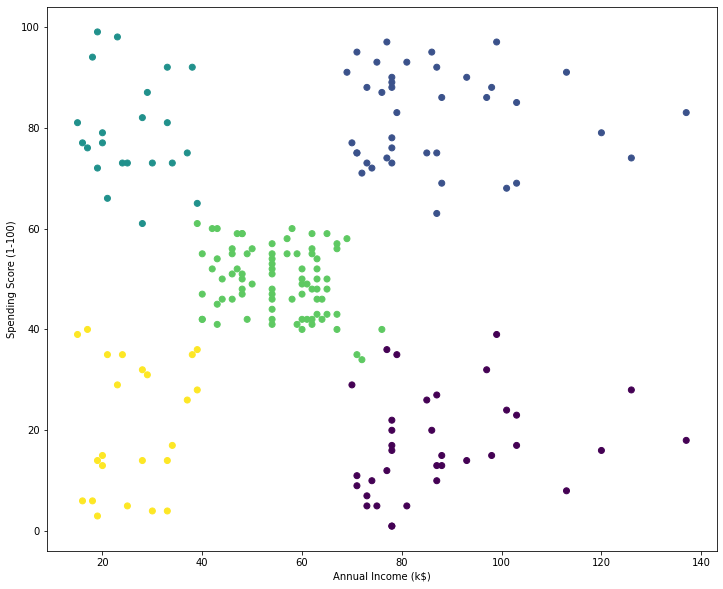

In [0]:
# Visualizar gráfico
plt.figure(figsize=(12,10))
plt.scatter(data_set_pandas['Annual Income (k$)'], data_set_pandas['Spending Score (1-100)'], c=data_set_pandas.prediction)
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show()